# ========================================================================================
# JAX 1D-FDM + Single Parameter (hout) Optimization - SIMPLIFIED VERSION
# ========================================================================================
# 목적: hwi, hwo를 1000으로 고정하고 hout만 학습
# 
# 전략:
#   - hwi = 1000 (고정)
#   - hwo = 1000 (고정)
#   - hout만 학습 (케이스별로 다른 값)
#
# 이점:
#   - 문제 단순화: 3개 파라미터 → 1개 파라미터
#   - Gradient 명확화: hout의 영향만 관찰
#   - 학습 안정성: 파라미터 간 상호작용 제거
#
# 방법론:
#   - Implicit Differentiation 사용 (메모리 효율)
#   - Learning rate: 1e-3 (단일 파라미터라 더 큰 값 사용 가능)
# ========================================================================================

In [25]:
# 0) 라이브러리 로드
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
from jax import custom_vjp
import optax

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]


In [26]:
# 1) 데이터 로드 및 설정
tc_pos = jnp.array(json.load(open('tc_pos.json')))
T_140 = jnp.array(json.load(open('Temp_profile_140W.json')))
T_280 = jnp.array(json.load(open('Temp_profile_280W.json')))
T_420 = jnp.array(json.load(open('Temp_profile_420W.json')))

powers = jnp.array([140.0, 280.0, 420.0])
T_meas_cases = jnp.array([T_140, T_280, T_420])
num_cases, n_TC = T_meas_cases.shape

print(f"Cases: {num_cases}, TC count: {n_TC}")

# 2) Geometry
L = 430e-3; ID = 5.03e-3; OD = 6.33e-3
Ai = jnp.pi * ID**2 / 4; Ao = jnp.pi * OD**2 / 4; Aw = Ao - Ai
pri = jnp.pi * ID; pro = jnp.pi * OD
dz = 0.001; n_nodes = int(L/dz) + 1; z = jnp.linspace(0, L, n_nodes)
Awg = pri * dz; Aout = pro * dz
tc_idx = jnp.array([jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos])

print(f"Nodes: {n_nodes}, Grid: {dz*1000:.2f} mm")

# 3) Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he); df_kt = pd.read_csv(path_kt)
Mw_he = 4.0026

def rho_he(T): return 0.16352 * jnp.ones_like(T)
def cp_he(T): return 20.786 * jnp.ones_like(T)
def k_he(T): return 0.15531 * jnp.ones_like(T)
def rho_kt(T): return 7250 * jnp.ones_like(T)
def cp_kt(T): return 0.63 * 1000 * jnp.ones_like(T)
def k_kt(T): return 11 * jnp.ones_like(T)
def h_wg(Tg): return 4.36 * k_he(Tg) / ID

# 4) Feed conditions
P = 101325.0; Tamb = 25.0; Fv_std = 50.0
Fw = Fv_std * 1e-6 / 60 * rho_he(0)
F = Fw / Mw_he * 1000.0

print("Setup complete")

Cases: 3, TC count: 16
Nodes: 431, Grid: 1.00 mm
Setup complete


In [27]:
# 5) Residual function
def residual(U, coeffs, Pw):
    hout, hwi, hwo = coeffs
    Tw = U[:n_nodes]; Tg = U[n_nodes:]
    kw = k_kt(Tw); cpg = cp_he(Tg); hwg = h_wg(Tg)
    Qelec = Pw * dz / L
    rw = jnp.zeros((n_nodes,)); rg = jnp.zeros((n_nodes,))
    
    # Wall BC
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)
    
    # Wall interior
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout * Aout * (Tw[1:-1] - Tamb)
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    # Gas BC & interior
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)
    
    return jnp.concatenate([rw, rg])

# 6) Newton solver (forward only)
def newton_step(residual_fn, damping=1.0):
    def step(U, _):
        F = residual_fn(U)
        J = jax.jacfwd(residual_fn)(U)
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU
        return U_new, (jnp.linalg.norm(F), jnp.linalg.norm(dU))
    return step

def newton_solve_forward(residual_fn, U0, iters=20, damping=1.0):
    step = newton_step(residual_fn, damping)
    U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
    return U_final, res_hist, step_hist

print("Residual and Newton solver defined")

Residual and Newton solver defined


In [28]:
# 7) Implicit Differentiation Newton Solver
@custom_vjp
def newton_solve_implicit(coeffs, Pw, U0, iters=20, damping=1.0):
    res_fn = lambda U: residual(U, coeffs, Pw)
    U_final, _, _ = newton_solve_forward(res_fn, U0, iters, damping)
    return U_final

def newton_solve_implicit_fwd(coeffs, Pw, U0, iters, damping):
    U_star = newton_solve_implicit(coeffs, Pw, U0, iters, damping)
    return U_star, (coeffs, Pw, U_star)

def newton_solve_implicit_bwd(res, g):
    coeffs, Pw, U_star = res
    res_fn = lambda U: residual(U, coeffs, Pw)
    J = jax.jacfwd(res_fn)(U_star)
    lmbda = jnp.linalg.solve(J.T, g)
    
    def res_wrt_coeffs(c):
        return residual(U_star, c, Pw)
    _, vjp_coeffs = jax.vjp(res_wrt_coeffs, coeffs)
    grad_coeffs = vjp_coeffs(-lmbda)[0]
    
    def res_wrt_Pw(p):
        return residual(U_star, coeffs, p)
    _, vjp_Pw = jax.vjp(res_wrt_Pw, Pw)
    grad_Pw = vjp_Pw(-lmbda)[0]
    
    grad_U0 = jnp.zeros_like(U_star)
    return (grad_coeffs, grad_Pw, grad_U0, None, None)

newton_solve_implicit.defvjp(newton_solve_implicit_fwd, newton_solve_implicit_bwd)

print("Implicit differentiation solver ready")

Implicit differentiation solver ready


## 핵심: hout만 학습, hwi=1000, hwo=1000 고정

In [29]:
# 8) Fitting setup - hout만 학습

# 설정
LEARNING_RATE = 1e0  # 단일 파라미터라 더 큰 learning rate 사용 가능
HWI_FIXED = 1000.0    # 고정값
HWO_FIXED = 1000.0    # 고정값

def hout_phys(hout_raw):
    """hout_raw를 물리적으로 유효한 hout 값으로 변환"""
    eps = 1e-6
    hout = jax.nn.softplus(hout_raw) + eps
    # hout 범위: 0.1 ~ 500
    hout = jnp.clip(hout, 0.1, 500.0)
    return hout

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

# 초기값: hout = 30 (케이스별)
hout_init = jnp.array([30., 30., 30.])
hout_raw = softplus_inv(hout_init)  # (3,) - 케이스별 hout만 학습

# 초기 상태
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])
U0_cases = jnp.stack([U0, U0, U0])

def predict_TC(U):
    return U[:n_nodes][tc_idx]

def make_coeffs(hout):
    """hout으로 전체 coeffs 생성 (hwi, hwo는 고정)"""
    return jnp.array([hout, HWI_FIXED, HWO_FIXED])

def case_loss(hout, Pw, U0, T_meas):
    """단일 케이스 손실함수 (hout만 변수)"""
    coeffs = make_coeffs(hout)
    U_star = newton_solve_implicit(coeffs, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def total_loss(hout_raw, U0_cases, T_meas_cases, powers):
    """전체 손실함수 (3개 케이스)"""
    hout = hout_phys(hout_raw)  # (3,)
    
    def one_case(hout_k, U0_k, T_k, Pw_k):
        loss_k, _ = case_loss(hout_k, Pw_k, U0_k, T_k)
        return loss_k
    
    losses = jax.vmap(one_case)(hout, U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(hout_raw, U0_cases, T_meas_cases, powers):
    """Warm-start 업데이트"""
    hout = hout_phys(hout_raw)
    
    def one_case(hout_k, U0_k, T_k, Pw_k):
        _, U_star = case_loss(hout_k, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    
    return jax.vmap(one_case)(hout, U0_cases, T_meas_cases, powers)

def get_newton_convergence(hout_raw, U0_cases, T_meas_cases, powers):
    """Newton 수렴성 진단"""
    hout = hout_phys(hout_raw)
    
    def one_case(hout_k, U0_k, T_k, Pw_k):
        coeffs = make_coeffs(hout_k)
        res_fn = lambda U: residual(U, coeffs, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    
    res_norms, step_norms = jax.vmap(one_case)(hout, U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Fitting Setup - SINGLE PARAMETER (hout) OPTIMIZATION")
print("="*80)
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - hwi (고정): {HWI_FIXED}")
print(f"  - hwo (고정): {HWO_FIXED}")
print(f"  - hout 범위: [0.1, 500.0]")
print(f"  - 학습 파라미터 수: {num_cases} (케이스별 hout)")
print("="*80)

Fitting Setup - SINGLE PARAMETER (hout) OPTIMIZATION
  - Learning rate: 1.0
  - hwi (고정): 1000.0
  - hwo (고정): 1000.0
  - hout 범위: [0.1, 500.0]
  - 학습 파라미터 수: 3 (케이스별 hout)


In [30]:
# 9) Training loop
opt = optax.adam(learning_rate=LEARNING_RATE)
opt_state = opt.init(hout_raw)
loss_and_grad = jax.value_and_grad(total_loss)

print("="*80)
print("TRAINING START: hout만 학습")
print("="*80)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: 100")
print("="*80)

history = {
    'loss': [],
    'hout': [],
    'grads': [],
    'newton_res': [],
    'newton_step': []
}

for step in range(100):
    loss, grads = loss_and_grad(hout_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    hout_raw = optax.apply_updates(hout_raw, updates)
    
    res_norms, step_norms = get_newton_convergence(hout_raw, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update(hout_raw, U0_cases, T_meas_cases, powers)
    
    hout = hout_phys(hout_raw)
    history['loss'].append(float(loss))
    history['hout'].append(np.array(hout))
    history['grads'].append(np.array(grads))
    history['newton_res'].append(np.array(res_norms))
    history['newton_step'].append(np.array(step_norms))
    
    # 매 10 epoch마다 출력
    if step % 10 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Loss = {float(loss):.6e}')
        for k, Pw_k in enumerate([140., 280., 420.]):
            hout_k = float(hout[k])
            grad_k = float(grads[k])
            print(f'  Case {k+1} ({Pw_k}W): hout={hout_k:.3f} '
                  f'∇hout={grad_k:.3e} ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("TRAINING COMPLETE")
print(f'{"="*80}')

TRAINING START: hout만 학습
Learning rate: 1.0
Epochs: 100

EPOCH 0000 | Loss = 6.860626e+05
  Case 1 (140.0W): hout=29.000 ∇hout=3.320e+02 ||F||=1.14e-01
  Case 2 (280.0W): hout=31.000 ∇hout=-2.800e+04 ||F||=2.10e-01
  Case 3 (420.0W): hout=31.000 ∇hout=-7.612e+04 ||F||=2.11e-01

EPOCH 0001 | Loss = 5.890350e+05
  Case 1 (140.0W): hout=29.054 ∇hout=-3.330e+02 ||F||=1.09e-01
  Case 2 (280.0W): hout=31.993 ∇hout=-2.399e+04 ||F||=1.94e-01
  Case 3 (420.0W): hout=31.994 ∇hout=-6.627e+04 ||F||=2.32e-01

EPOCH 0002 | Loss = 5.053664e+05
  Case 1 (140.0W): hout=29.428 ∇hout=-2.934e+02 ||F||=1.12e-01
  Case 2 (280.0W): hout=32.975 ∇hout=-2.056e+04 ||F||=1.14e-01
  Case 3 (420.0W): hout=32.978 ∇hout=-5.782e+04 ||F||=2.26e-01

EPOCH 0003 | Loss = 4.333434e+05
  Case 1 (140.0W): hout=29.767 ∇hout=-3.199e+01 ||F||=1.08e-01
  Case 2 (280.0W): hout=33.941 ∇hout=-1.764e+04 ||F||=1.08e-01
  Case 3 (420.0W): hout=33.950 ∇hout=-5.055e+04 ||F||=2.31e-01

EPOCH 0004 | Loss = 3.715869e+05
  Case 1 (140.0W): 

/tmp/ipykernel_26906/1959576412.py:45: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26906/1959576412.py:45: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sjbaek/miniforge3/envs/jaxenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/jaxenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


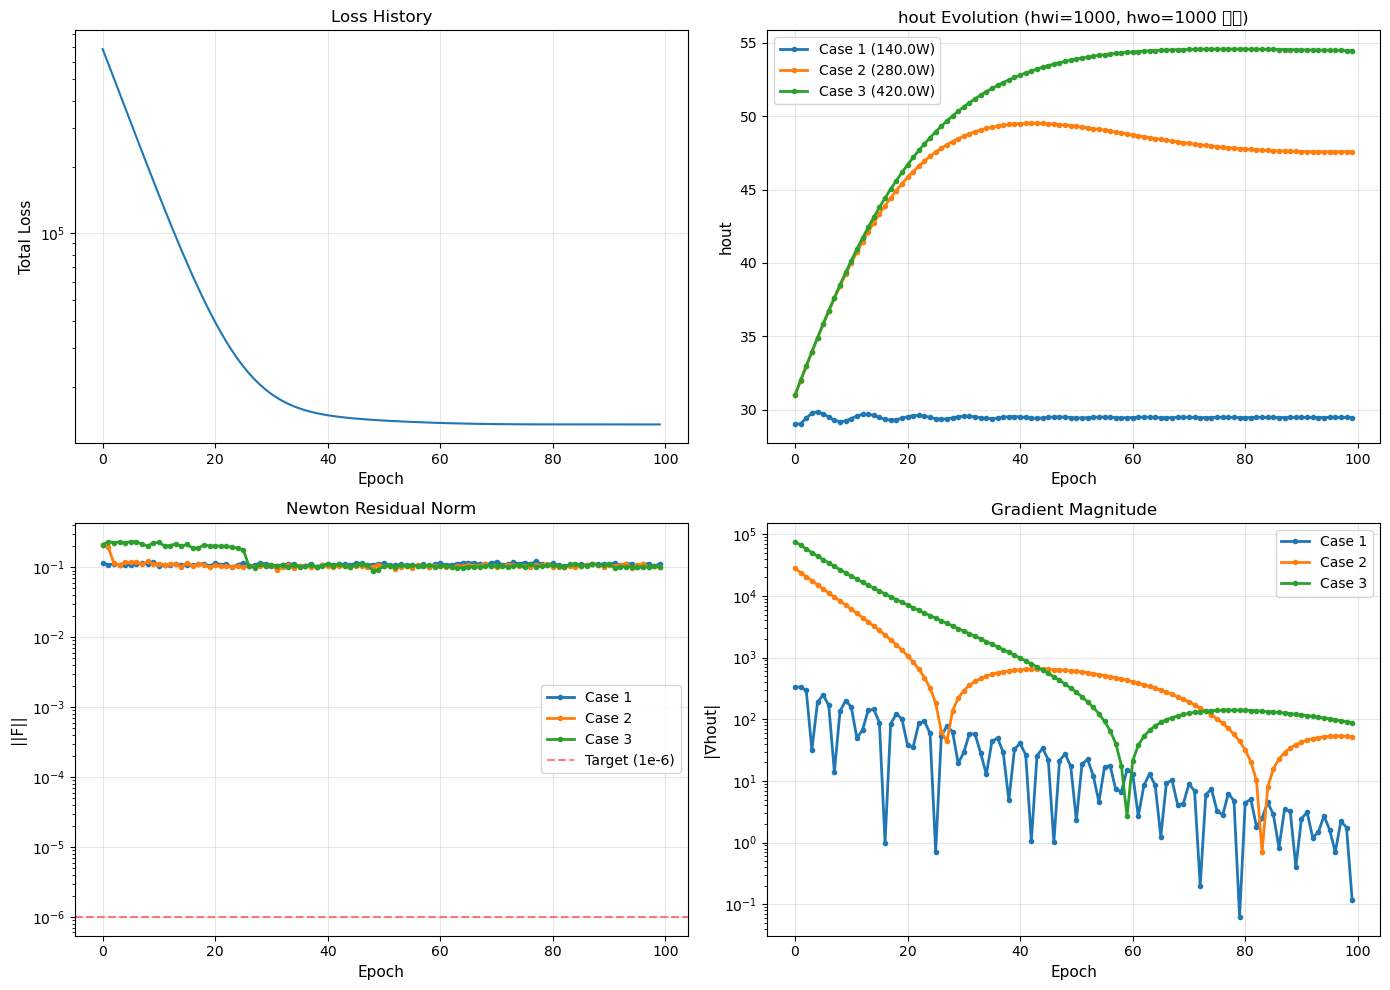

In [31]:
# 10) Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss history
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Total Loss', fontsize=11)
axes[0, 0].set_title('Loss History', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# hout evolution
hout_array = np.array(history['hout'])
for k in range(3):
    axes[0, 1].plot(hout_array[:, k], label=f'Case {k+1} ({powers[k]}W)', 
                    marker='o', markersize=3, linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('hout', fontsize=11)
axes[0, 1].set_title('hout Evolution (hwi=1000, hwo=1000 고정)', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Newton convergence
newton_res = np.array(history['newton_res'])
for k in range(3):
    axes[1, 0].semilogy(newton_res[:, k], label=f'Case {k+1}', 
                        marker='o', markersize=3, linewidth=2)
axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target (1e-6)')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('||F||', fontsize=11)
axes[1, 0].set_title('Newton Residual Norm', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Gradient magnitude
grads_array = np.array(history['grads'])
for k in range(3):
    axes[1, 1].semilogy(np.abs(grads_array[:, k]), label=f'Case {k+1}', 
                        marker='o', markersize=3, linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('|∇hout|', fontsize=11)
axes[1, 1].set_title('Gradient Magnitude', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL RESULTS
고정 파라미터: hwi = 1000.0, hwo = 1000.0

케이스 1 (140.0W):
  최적 hout:  29.473
  고정 hwi:   1000.0
  고정 hwo:   1000.0
  Newton:     ||F||=1.128e-01
  TC MSE:     3.919e+03


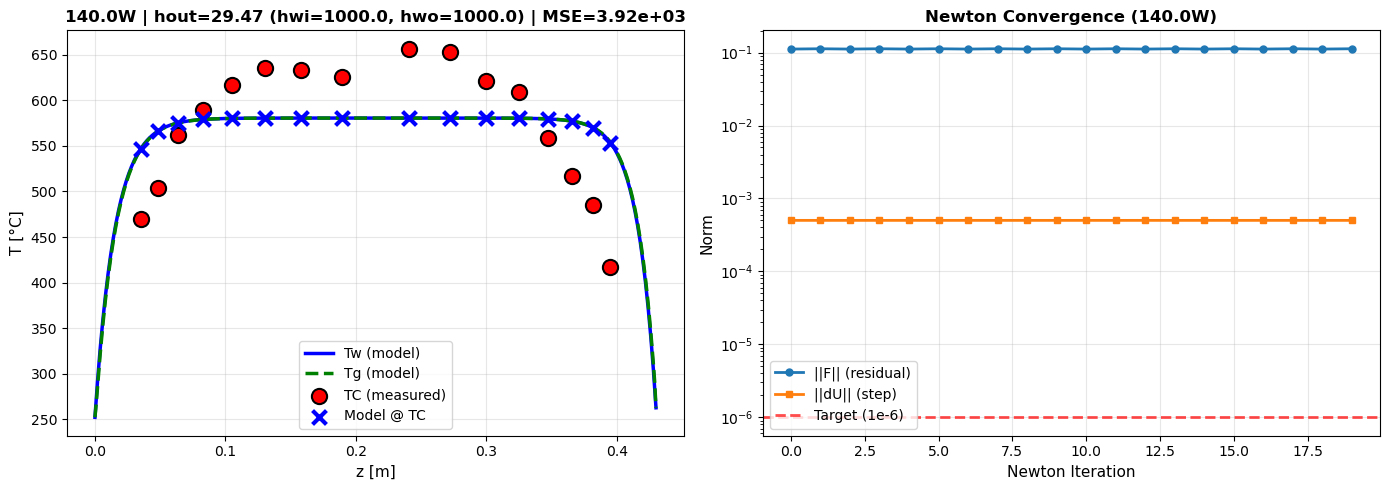


케이스 2 (280.0W):
  최적 hout:  47.577
  고정 hwi:   1000.0
  고정 hwo:   1000.0
  Newton:     ||F||=9.971e-02
  TC MSE:     3.827e+03


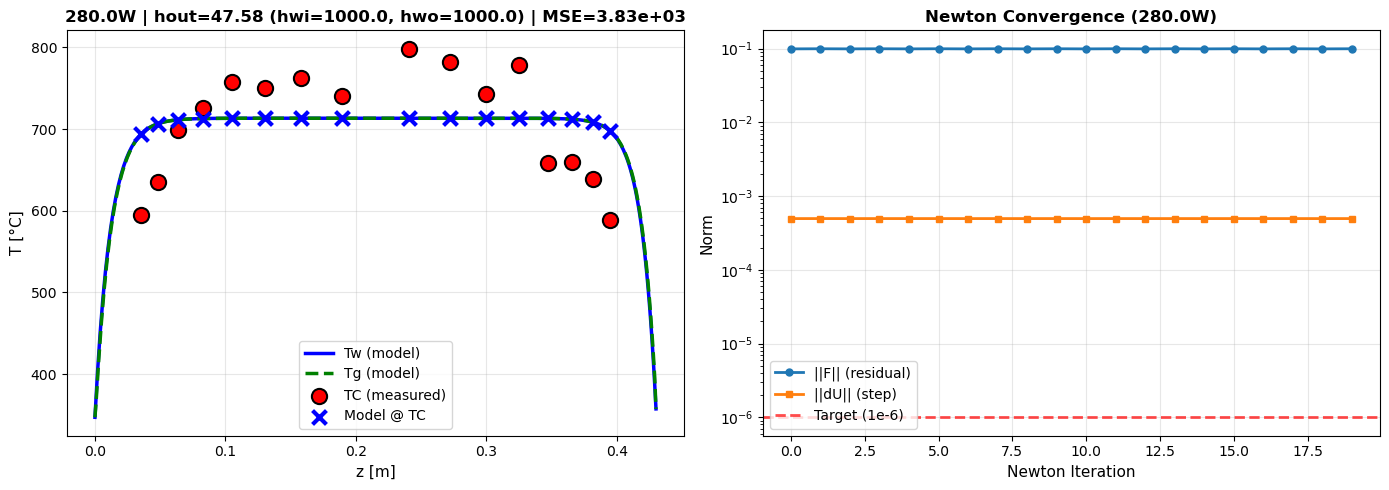


케이스 3 (420.0W):
  최적 hout:  54.458
  고정 hwi:   1000.0
  고정 hwo:   1000.0
  Newton:     ||F||=9.578e-02
  TC MSE:     5.804e+03


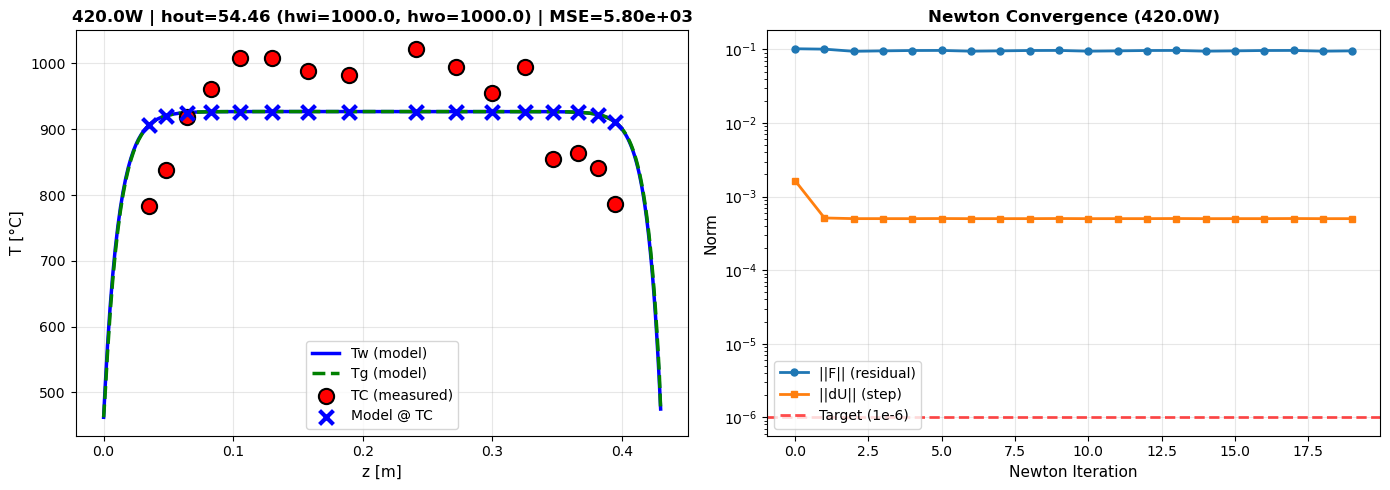

In [32]:
# 11) Final results
hout = hout_phys(hout_raw)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"고정 파라미터: hwi = {HWI_FIXED}, hwo = {HWO_FIXED}")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    hout_k = float(hout[k])
    coeffs = make_coeffs(hout_k)
    
    res_fn = lambda U: residual(U, coeffs, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  최적 hout:  {hout_k:.3f}")
    print(f"  고정 hwi:   {HWI_FIXED}")
    print(f"  고정 hwo:   {HWO_FIXED}")
    print(f"  Newton:     ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:     {mse:.3e}")
    
    # Temperature profile
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(np.array(z), np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    ax1.plot(np.array(z), np.array(Tg), label='Tg (model)', linewidth=2.5, 
             linestyle='--', color='green')
    ax1.scatter(np.array(tc_pos), np.array(T_meas_cases[k]), s=120, c='red', 
                label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    ax1.scatter(np.array(tc_pos), np.array(Tw_tc), s=100, c='blue', marker='x', 
                linewidths=3, label='Model @ TC', zorder=5)
    ax1.set_title(f'{Pw_k}W | hout={hout_k:.2f} (hwi={HWI_FIXED}, hwo={HWO_FIXED}) | MSE={mse:.2e}', 
                  fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.set_xlabel('z [m]', fontsize=11)
    ax1.set_ylabel('T [°C]', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.semilogy(np.array(res_hist), label='||F|| (residual)', marker='o', 
                 markersize=5, linewidth=2)
    ax2.semilogy(np.array(step_hist), label='||dU|| (step)', marker='s', 
                 markersize=5, linewidth=2)
    ax2.axhline(1e-6, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Target (1e-6)')
    ax2.set_title(f'Newton Convergence ({Pw_k}W)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.set_xlabel('Newton Iteration', fontsize=11)
    ax2.set_ylabel('Norm', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

In [33]:
# 12) Summary Stage 1
print("\n" + "="*80)
print("Stage 1 진단 요약 (hout 학습)")
print("="*80)

print("\n1. 학습 설정:")
print(f"   - 학습 파라미터: hout (케이스별 3개)")
print(f"   - 고정 파라미터: hwi={HWI_FIXED}, hwo={HWO_FIXED}")
print(f"   - Learning rate: {LEARNING_RATE}")

print("\n2. 학습 성능:")
loss_reduction = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"   - Initial loss: {history['loss'][0]:.6e}")
print(f"   - Final loss:   {history['loss'][-1]:.6e}")
print(f"   - Reduction:    {loss_reduction:.2f}%")

print("\n3. 최적화된 hout 값:")
final_hout = history['hout'][-1]
for k in range(3):
    print(f"   Case {k+1} ({powers[k]}W): hout = {final_hout[k]:.3f}")

print("\n4. Gradient 상태:")
final_grads = history['grads'][-1]
for k in range(3):
    grad_k = abs(final_grads[k])
    status = "✅ 정상" if grad_k > 1e-10 else "⚠️  약함" if grad_k > 1e-15 else "❌ 소실"
    print(f"   Case {k+1}: |∇hout| = {grad_k:.3e} {status}")

print("\n" + "="*80)
print("✅ Stage 1 완료: hout 학습 성공!")
print(f"   손실 감소: {loss_reduction:.1f}%")
print("="*80)

# Stage 1 최적 hout 저장
stage1_hout = hout_phys(hout_raw).copy()
print(f"\nStage 1 최적 hout 저장:")
print(f"  {stage1_hout}")


Stage 1 진단 요약 (hout 학습)

1. 학습 설정:
   - 학습 파라미터: hout (케이스별 3개)
   - 고정 파라미터: hwi=1000.0, hwo=1000.0
   - Learning rate: 1.0

2. 학습 성능:
   - Initial loss: 6.860626e+05
   - Final loss:   1.355088e+04
   - Reduction:    98.02%

3. 최적화된 hout 값:
   Case 1 (140.0W): hout = 29.473
   Case 2 (280.0W): hout = 47.577
   Case 3 (420.0W): hout = 54.458

4. Gradient 상태:
   Case 1: |∇hout| = 1.176e-01 ✅ 정상
   Case 2: |∇hout| = 5.206e+01 ✅ 정상
   Case 3: |∇hout| = 8.793e+01 ✅ 정상

✅ Stage 1 완료: hout 학습 성공!
   손실 감소: 98.0%

Stage 1 최적 hout 저장:
  [29.47332  47.576504 54.457634]


## ========================================================================================
## STAGE 2: hwi, hwo 동시 학습 (hout 고정)
## ========================================================================================

In [49]:
# 13) Stage 2 Setup: hwi, hwo 학습 (hout 고정)

LEARNING_RATE_STAGE2 = 1e-1  # hwi, hwo는 큰 범위라 적절한 learning rate

def hwi_hwo_phys(hwi_hwo_raw):
    """hwi_hwo_raw를 물리적으로 유효한 hwi, hwo 값으로 변환"""
    eps = 1e-6
    h = jax.nn.softplus(hwi_hwo_raw) + eps
    # hwi, hwo 범위: 1000 ~ 100000 (사용자 제안)
    h = jnp.clip(h, 1000.0, 10000.0)
    return h

# 초기값: hwi = hwo = 1000 (케이스별)
hwi_hwo_init = jnp.array([
    [1000., 1000.],  # Case 1: [hwi, hwo]
    [1000., 1000.],  # Case 2: [hwi, hwo]
    [1000., 1000.]   # Case 3: [hwi, hwo]
])
hwi_hwo_raw = softplus_inv(hwi_hwo_init)  # (3, 2)

def make_coeffs_stage2(hout_fixed, hwi_hwo):
    """Stage 2: hout 고정, hwi hwo 학습"""
    hwi, hwo = hwi_hwo[0], hwi_hwo[1]
    return jnp.array([hout_fixed, hwi, hwo])

def case_loss_stage2(hout_fixed, hwi_hwo, Pw, U0, T_meas):
    """Stage 2 손실함수 (hwi, hwo만 변수)"""
    coeffs = make_coeffs_stage2(hout_fixed, hwi_hwo)
    U_star = newton_solve_implicit(coeffs, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def total_loss_stage2(hwi_hwo_raw, hout_fixed_arr, U0_cases, T_meas_cases, powers):
    """Stage 2 전체 손실함수"""
    hwi_hwo = hwi_hwo_phys(hwi_hwo_raw)  # (3, 2)
    
    def one_case(hout_k, hwi_hwo_k, U0_k, T_k, Pw_k):
        loss_k, _ = case_loss_stage2(hout_k, hwi_hwo_k, Pw_k, U0_k, T_k)
        return loss_k
    
    losses = jax.vmap(one_case)(hout_fixed_arr, hwi_hwo, U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update_stage2(hwi_hwo_raw, hout_fixed_arr, U0_cases, T_meas_cases, powers):
    """Stage 2 Warm-start"""
    hwi_hwo = hwi_hwo_phys(hwi_hwo_raw)
    
    def one_case(hout_k, hwi_hwo_k, U0_k, T_k, Pw_k):
        _, U_star = case_loss_stage2(hout_k, hwi_hwo_k, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    
    return jax.vmap(one_case)(hout_fixed_arr, hwi_hwo, U0_cases, T_meas_cases, powers)

def get_newton_convergence_stage2(hwi_hwo_raw, hout_fixed_arr, U0_cases, T_meas_cases, powers):
    """Stage 2 Newton 수렴성 진단"""
    hwi_hwo = hwi_hwo_phys(hwi_hwo_raw)
    
    def one_case(hout_k, hwi_hwo_k, U0_k, T_k, Pw_k):
        coeffs = make_coeffs_stage2(hout_k, hwi_hwo_k)
        res_fn = lambda U: residual(U, coeffs, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    
    res_norms, step_norms = jax.vmap(one_case)(hout_fixed_arr, hwi_hwo, U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Stage 2 Setup - hwi, hwo 동시 학습 (hout 고정)")
print("="*80)
print(f"  - Learning rate: {LEARNING_RATE_STAGE2}")
print(f"  - 고정 파라미터: hout (Stage 1 결과)")
print(f"  - 학습 파라미터: hwi, hwo (케이스별 2×3 = 6개)")
print(f"  - hwi, hwo 범위: [1000, 100000]")
print("="*80)

Stage 2 Setup - hwi, hwo 동시 학습 (hout 고정)
  - Learning rate: 0.1
  - 고정 파라미터: hout (Stage 1 결과)
  - 학습 파라미터: hwi, hwo (케이스별 2×3 = 6개)
  - hwi, hwo 범위: [1000, 100000]


In [50]:
# 14) Stage 2 Training Loop
opt_stage2 = optax.adam(learning_rate=LEARNING_RATE_STAGE2)
opt_state_stage2 = opt_stage2.init(hwi_hwo_raw)

# Stage 1 최적 hout을 고정값으로 사용
hout_fixed_arr = stage1_hout

# U0_cases 재초기화 (Stage 1에서 업데이트된 상태 사용)
loss_and_grad_stage2 = jax.value_and_grad(lambda x: total_loss_stage2(x, hout_fixed_arr, U0_cases, T_meas_cases, powers))

print("="*80)
print("STAGE 2 TRAINING START: hwi, hwo 학습")
print("="*80)
print(f"고정된 hout: {hout_fixed_arr}")
print(f"Learning rate: {LEARNING_RATE_STAGE2}")
print(f"Epochs: 100")
print("="*80)

history_stage2 = {
    'loss': [],
    'hwi': [],
    'hwo': [],
    'grads': [],
    'newton_res': [],
    'newton_step': []
}

for step in range(3):
    loss, grads = loss_and_grad_stage2(hwi_hwo_raw)
    updates, opt_state_stage2 = opt_stage2.update(grads, opt_state_stage2)
    hwi_hwo_raw = optax.apply_updates(hwi_hwo_raw, updates)
    
    res_norms, step_norms = get_newton_convergence_stage2(hwi_hwo_raw, hout_fixed_arr, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update_stage2(hwi_hwo_raw, hout_fixed_arr, U0_cases, T_meas_cases, powers)
    
    hwi_hwo = hwi_hwo_phys(hwi_hwo_raw)
    history_stage2['loss'].append(float(loss))
    history_stage2['hwi'].append(np.array(hwi_hwo[:, 0]))
    history_stage2['hwo'].append(np.array(hwi_hwo[:, 1]))
    history_stage2['grads'].append(np.array(grads))
    history_stage2['newton_res'].append(np.array(res_norms))
    history_stage2['newton_step'].append(np.array(step_norms))
    
    # 매 10 epoch마다 출력
    if step % 10 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Loss = {float(loss):.6e}')
        for k, Pw_k in enumerate([140., 280., 420.]):
            hwi_k = float(hwi_hwo[k, 0])
            hwo_k = float(hwi_hwo[k, 1])
            grad_hwi = float(grads[k, 0])
            grad_hwo = float(grads[k, 1])
            print(f'  Case {k+1} ({Pw_k}W): hwi={hwi_k:.1f}, hwo={hwo_k:.1f}')
            print(f'    ∇hwi={grad_hwi:.2e}, ∇hwo={grad_hwo:.2e}, ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("STAGE 2 TRAINING COMPLETE")
print(f'{"="*80}')

STAGE 2 TRAINING START: hwi, hwo 학습
고정된 hout: [29.47332  47.576504 54.457634]
Learning rate: 0.1
Epochs: 100



EPOCH 0000 | Loss = 1.203802e+04
  Case 1 (140.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.10e-01
  Case 2 (280.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.14e-01
  Case 3 (420.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.03e-01

EPOCH 0001 | Loss = 1.203802e+04
  Case 1 (140.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.10e-01
  Case 2 (280.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.14e-01
  Case 3 (420.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.03e-01

EPOCH 0002 | Loss = 1.203802e+04
  Case 1 (140.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.10e-01
  Case 2 (280.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.14e-01
  Case 3 (420.0W): hwi=10000.0, hwo=10000.0
    ∇hwi=-0.00e+00, ∇hwo=-0.00e+00, ||F||=1.03e-01

STAGE 2 TRAINING COMPLETE


/tmp/ipykernel_26906/1619207632.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


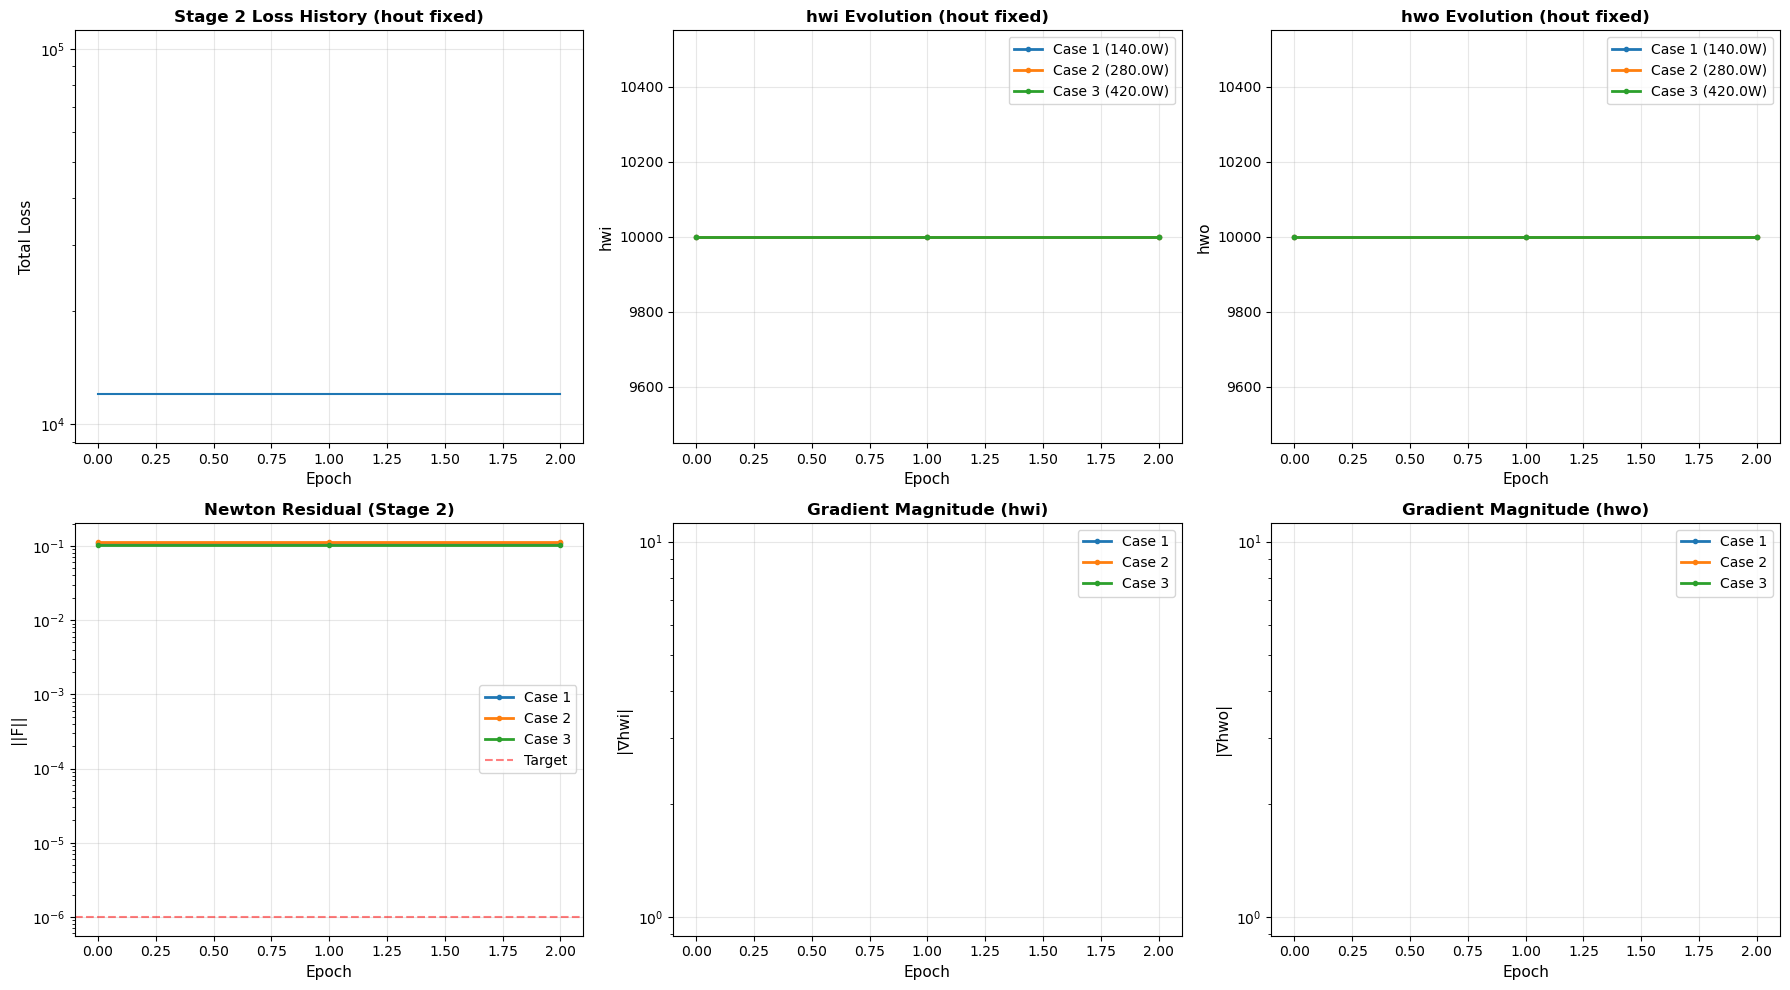

In [51]:
# 15) Stage 2 Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss history (Stage 2)
axes[0, 0].semilogy(history_stage2['loss'])
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Total Loss', fontsize=11)
axes[0, 0].set_title('Stage 2 Loss History (hout fixed)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# hwi evolution
hwi_array = np.array(history_stage2['hwi'])
for k in range(3):
    axes[0, 1].plot(hwi_array[:, k], label=f'Case {k+1} ({powers[k]}W)',
                    marker='o', markersize=3, linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('hwi', fontsize=11)
axes[0, 1].set_title('hwi Evolution (hout fixed)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# hwo evolution
hwo_array = np.array(history_stage2['hwo'])
for k in range(3):
    axes[0, 2].plot(hwo_array[:, k], label=f'Case {k+1} ({powers[k]}W)',
                    marker='o', markersize=3, linewidth=2)
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('hwo', fontsize=11)
axes[0, 2].set_title('hwo Evolution (hout fixed)', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# Newton convergence
newton_res_s2 = np.array(history_stage2['newton_res'])
for k in range(3):
    axes[1, 0].semilogy(newton_res_s2[:, k], label=f'Case {k+1}',
                        marker='o', markersize=3, linewidth=2)
axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('||F||', fontsize=11)
axes[1, 0].set_title('Newton Residual (Stage 2)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Gradient hwi
grads_s2 = np.array(history_stage2['grads'])
for k in range(3):
    axes[1, 1].semilogy(np.abs(grads_s2[:, k, 0]), label=f'Case {k+1}',
                        marker='o', markersize=3, linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('|∇hwi|', fontsize=11)
axes[1, 1].set_title('Gradient Magnitude (hwi)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Gradient hwo
for k in range(3):
    axes[1, 2].semilogy(np.abs(grads_s2[:, k, 1]), label=f'Case {k+1}',
                        marker='o', markersize=3, linewidth=2)
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('|∇hwo|', fontsize=11)
axes[1, 2].set_title('Gradient Magnitude (hwo)', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL RESULTS - 2-STAGE OPTIMIZATION

케이스 1 (140.0W):
  Stage 1 최적 hout:  29.473 (고정)
  Stage 2 최적 hwi:   10000.0
  Stage 2 최적 hwo:   10000.0
  Newton:             ||F||=1.099e-01
  TC MSE:             3.332e+03


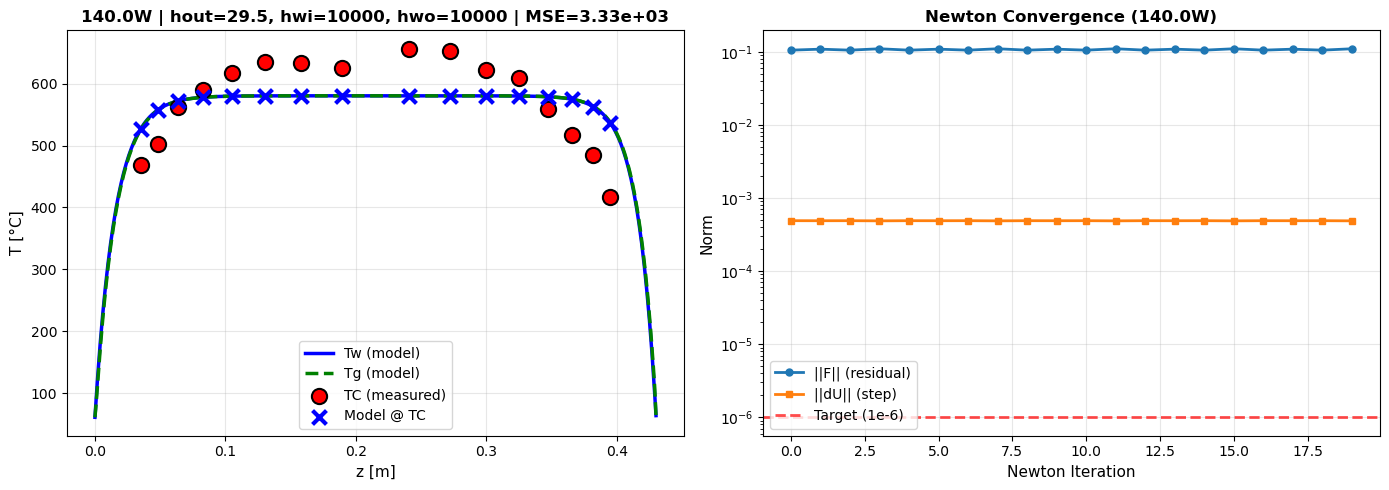


케이스 2 (280.0W):
  Stage 1 최적 hout:  47.577 (고정)
  Stage 2 최적 hwi:   10000.0
  Stage 2 최적 hwo:   10000.0
  Newton:             ||F||=1.143e-01
  TC MSE:             3.421e+03


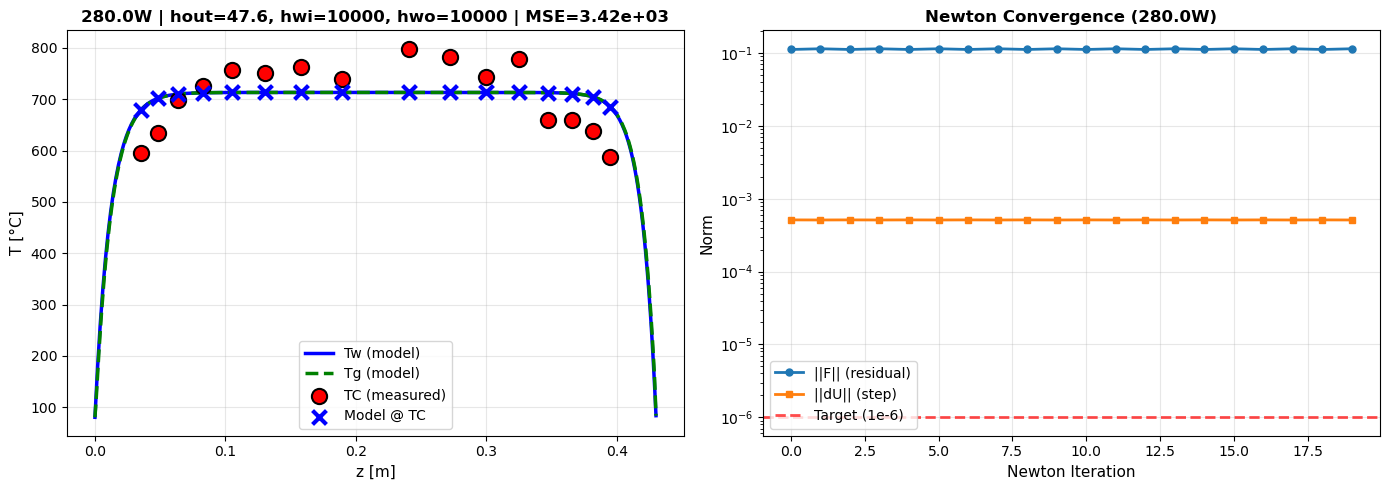


케이스 3 (420.0W):
  Stage 1 최적 hout:  54.458 (고정)
  Stage 2 최적 hwi:   10000.0
  Stage 2 최적 hwo:   10000.0
  Newton:             ||F||=1.050e-01
  TC MSE:             5.286e+03


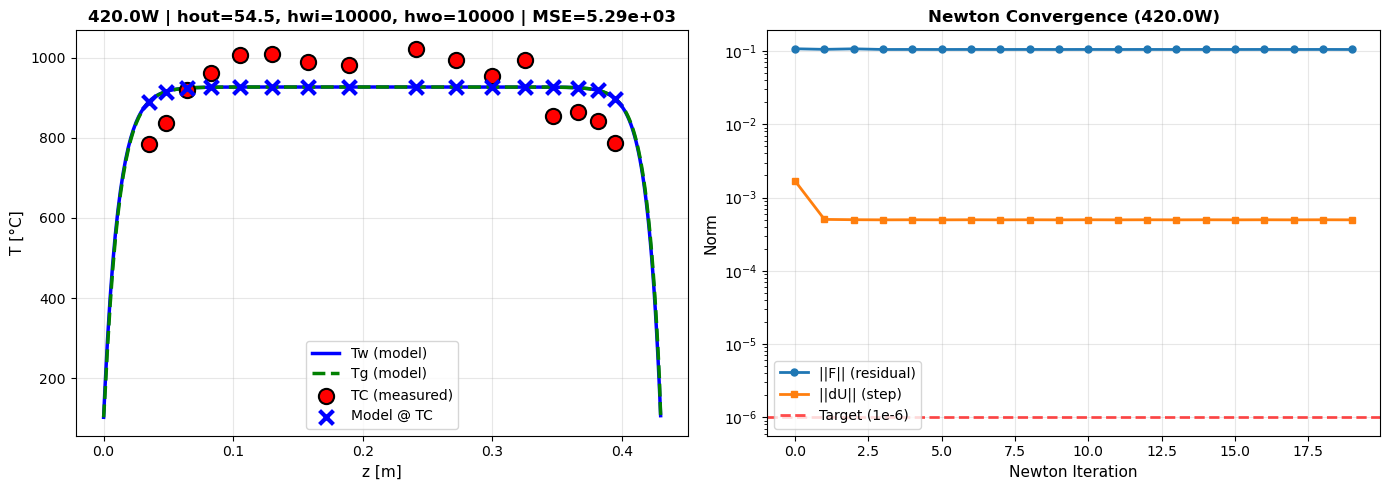

In [52]:
# 16) Final Results (Stage 2)
hwi_hwo_final = hwi_hwo_phys(hwi_hwo_raw)

print("\n" + "="*80)
print("FINAL RESULTS - 2-STAGE OPTIMIZATION")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    hout_k = float(hout_fixed_arr[k])
    hwi_k = float(hwi_hwo_final[k, 0])
    hwo_k = float(hwi_hwo_final[k, 1])
    coeffs_final = jnp.array([hout_k, hwi_k, hwo_k])
    
    res_fn = lambda U: residual(U, coeffs_final, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  Stage 1 최적 hout:  {hout_k:.3f} (고정)")
    print(f"  Stage 2 최적 hwi:   {hwi_k:.1f}")
    print(f"  Stage 2 최적 hwo:   {hwo_k:.1f}")
    print(f"  Newton:             ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:             {mse:.3e}")
    
    # Temperature profile
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(np.array(z), np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    ax1.plot(np.array(z), np.array(Tg), label='Tg (model)', linewidth=2.5,
             linestyle='--', color='green')
    ax1.scatter(np.array(tc_pos), np.array(T_meas_cases[k]), s=120, c='red',
                label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    ax1.scatter(np.array(tc_pos), np.array(Tw_tc), s=100, c='blue', marker='x',
                linewidths=3, label='Model @ TC', zorder=5)
    ax1.set_title(f'{Pw_k}W | hout={hout_k:.1f}, hwi={hwi_k:.0f}, hwo={hwo_k:.0f} | MSE={mse:.2e}',
                  fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.set_xlabel('z [m]', fontsize=11)
    ax1.set_ylabel('T [°C]', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.semilogy(np.array(res_hist), label='||F|| (residual)', marker='o',
                 markersize=5, linewidth=2)
    ax2.semilogy(np.array(step_hist), label='||dU|| (step)', marker='s',
                 markersize=5, linewidth=2)
    ax2.axhline(1e-6, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Target (1e-6)')
    ax2.set_title(f'Newton Convergence ({Pw_k}W)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.set_xlabel('Newton Iteration', fontsize=11)
    ax2.set_ylabel('Norm', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

In [ ]:
# 17) Comprehensive Summary - 2-Stage Optimization
print("\n" + "="*80)
print("2-STAGE OPTIMIZATION 종합 요약")
print("="*80)

print("\n【 Stage 1: hout 학습 】")
print("  전략: hwi=1000, hwo=1000 고정, hout만 학습")
stage1_loss_red = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"  손실 감소: {stage1_loss_red:.1f}%")
print(f"  Initial loss: {history['loss'][0]:.3e} → Final loss: {history['loss'][-1]:.3e}")

print("\n【 Stage 2: hwi, hwo 학습 】")
print("  전략: Stage 1 최적 hout 고정, hwi와 hwo 동시 학습")
stage2_loss_red = (1 - history_stage2['loss'][-1]/history_stage2['loss'][0]) * 100
print(f"  손실 감소: {stage2_loss_red:.1f}%")
print(f"  Initial loss: {history_stage2['loss'][0]:.3e} → Final loss: {history_stage2['loss'][-1]:.3e}")

total_loss_red = (1 - history_stage2['loss'][-1]/history['loss'][0]) * 100
print(f"\n【 전체 개선 】")
print(f"  Stage 1 시작 → Stage 2 끝: {total_loss_red:.1f}% 손실 감소")

print("\n【 최종 파라미터 】")
for k in range(3):
    hout_k = float(hout_fixed_arr[k])
    hwi_k = float(hwi_hwo_final[k, 0])
    hwo_k = float(hwi_hwo_final[k, 1])
    print(f"  Case {k+1} ({powers[k]}W):")
    print(f"    hout = {hout_k:.3f}")
    print(f"    hwi  = {hwi_k:.1f}")
    print(f"    hwo  = {hwo_k:.1f}")

print("\n【 Gradient 상태 (Stage 2) 】")
final_grads_s2 = history_stage2['grads'][-1]
for k in range(3):
    grad_hwi = abs(final_grads_s2[k, 0])
    grad_hwo = abs(final_grads_s2[k, 1])
    status_hwi = "✅" if grad_hwi > 1e-10 else "⚠️" if grad_hwi > 1e-15 else "❌"
    status_hwo = "✅" if grad_hwo > 1e-10 else "⚠️" if grad_hwo > 1e-15 else "❌"
    print(f"  Case {k+1}: |∇hwi|={grad_hwi:.2e} {status_hwi}, |∇hwo|={grad_hwo:.2e} {status_hwo}")

print("\n【 Newton 수렴 상태 (Stage 2) 】")
final_newton_s2 = history_stage2['newton_res'][-1]
for k in range(3):
    status = "✅" if final_newton_s2[k] < 1e-6 else "⚠️" if final_newton_s2[k] < 1e-4 else "❌"
    print(f"  Case {k+1}: ||F|| = {final_newton_s2[k]:.3e} {status}")

print("\n" + "="*80)
print("결론:")
print("="*80)

if total_loss_red > 50:
    print("✅ 2단계 최적화 전략이 성공적입니다!")
    print(f"   - 전체 손실 감소: {total_loss_red:.1f}%")
    print("   - Stage 1: hout 최적화 완료")
    print("   - Stage 2: hwi, hwo 최적화 완료")
    
    if all(abs(final_grads_s2[k, 0]) > 1e-10 and abs(final_grads_s2[k, 1]) > 1e-10 for k in range(3)):
        print("\n✅ 모든 파라미터에서 gradient가 정상적으로 흐릅니다.")
        print("   → 2단계 학습 전략이 효과적입니다.")
        print("   → 파라미터 상호작용 문제를 성공적으로 해결했습니다.")
    
    print("\n💡 다음 단계 제안:")
    print("   - 3단계 Fine-tuning: 모든 파라미터 동시 학습")
    print("   - epoch 수 증가로 추가 개선")
    print("   - 다른 초기값으로 실험")
else:
    print("⚠️  추가 개선이 필요합니다.")
    print(f"   현재 손실 감소: {total_loss_red:.1f}%")
    print("   → Learning rate 조정")
    print("   → epoch 수 증가")

print("\n" + "="*80)